## Import Necessary Libraries

In [67]:
# System
import pathlib
import glob
import os, os.path, shutil
# Data Exploration
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pandas as pd
import seaborn as sns
from PIL import Image
# Machine Learning
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
#Deep Learning
import tensorflow as tf
import keras
from keras.utils import plot_model ######
from keras import backend as K ##########
from keras import metrics
from keras.regularizers import l2,l1
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.preprocessing.image import img_to_array, ImageDataGenerator, array_to_img, load_img
from keras.metrics import AUC
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Something unknown :)
import pydot
from dask import bag,  diagnostics

## Data Directory

In [68]:
train_dir = 'split/train'
train_NORMAL_dir = 'split/train/NORMAL/'
train_PNEUMONIA_dir = 'split/train/PNEUMONIA/'

validation_dir = 'split/validation'
validation_NORMAL_dir = 'split/validation/NORMAL/'
validation_PNEUMONIA_dir = 'split/validation/PNEUMONIA/'

test_dir = 'split/test'
test_NORMAL_dir = 'split/test/NORMAL/'
test_PNEUMONIA_dir = 'split/test/PNEUMONIA/'

## Function for results visualization

In [69]:
def create_charts(cnn, cnn_model):
    """
    
    """
    
    ## Define train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define train & validation AUC
    train_auc = cnn_model.history['acc']
    val_auc = cnn_model.history['val_acc']
    
    ## Define y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION AUC
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
      # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['Normal', 'Pneumonia']

      # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout()
    
    ## Summary Statistics
    TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

## Model 5: Convolution Layers = 3, Dense = 64, Epochs = 200, Data Augmentation

In [75]:
def make_data_generator(
    train_datagen, train_dir, 
    val_datagen, val_dir, 
    test_datagen, test_dir):
    """
    
    """
    
    datagen_lst = [train_datagen, val_datagen, test_datagen]
    directory_lst = [train_dir, val_dir, test_dir]
    generator_lst = []
    for generator, directory in zip(datagen_lst, directory_lst):
        if directory == train_dir:
            shuffle = True
        else:
            shuffle = False
        g = generator.flow_from_directory(directory = directory,
                                         target_size = (64,64),
                                         batch_size = 128,
                                         color_mode = 'grayscale',
                                         class_mode = 'binary',
                                         shuffle = shuffle,
                                         seed = 42)
        generator_lst.append(g)
    
    return generator_lst

In [76]:
# Load the images

train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   zoom_range = 0.2,
                                   shear_range = 0.2,
                                   horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator,val_generator, test_generator = make_data_generator(
    train_datagen, train_dir,
    val_datagen, validation_dir,
    test_datagen, test_dir)

Found 4099 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 585 images belonging to 2 classes.


In [78]:
def build_model_1():
    
    # Design the model
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(64, 64, 1)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))

    cnn.add(Flatten())

    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dense(1, activation='sigmoid'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

cnn = build_model_1()

In [27]:
# Train the model

cnn_model = cnn.fit_generator(train_generator,
                              epochs = 200,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1)

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
33/33 [==============================] - 26s 789ms/step - loss: 0.6256 - acc: 0.6720 - val_loss: 0.5602 - val_acc: 0.7295
Epoch 2/200
33/33 [==============================] - 25s 755ms/step - loss: 0.5375 - acc: 0.7367 - val_loss: 0.3674 - val_acc: 0.8336
Epoch 3/200
33/33 [==============================] - 25s 754ms/step - loss: 0.4034 - acc: 0.8217 - val_loss: 0.3283 - val_acc: 0.8635
Epoch 4/200
33/33 [==============================] - 25s 759ms/step - loss: 0.2942 - acc: 0.8733 - val_loss: 0.2474 - val_acc: 0.9010
Epoch 5/200
33/33 [==============================] - 25s 751ms/step - loss: 0.2680 - acc: 0.8900 - val_loss: 0.3649 - val_acc: 0.7961
Epoch 6/200
33/33 [==============================] - 25s 749ms/step - loss: 0.3195 - acc: 0.8613 - val_loss: 0.2384 - val_acc: 0.9010
Epoch 7/200
33/33 [==============================] - 25s 750ms/step - loss: 0.2730 - acc: 0.8834 - val_loss: 0.2967 - val_acc: 0.8720
Epoch 8/200
33/33 [==============================] - 25s 768ms

Epoch 62/200
33/33 [==============================] - 25s 754ms/step - loss: 0.1310 - acc: 0.9505 - val_loss: 0.1228 - val_acc: 0.9590
Epoch 63/200
33/33 [==============================] - 25s 755ms/step - loss: 0.1311 - acc: 0.9511 - val_loss: 0.1450 - val_acc: 0.9411
Epoch 64/200
33/33 [==============================] - 25s 760ms/step - loss: 0.1363 - acc: 0.9470 - val_loss: 0.1362 - val_acc: 0.9454
Epoch 65/200
33/33 [==============================] - 25s 750ms/step - loss: 0.1169 - acc: 0.9545 - val_loss: 0.1270 - val_acc: 0.9608
Epoch 66/200
33/33 [==============================] - 25s 758ms/step - loss: 0.1400 - acc: 0.9470 - val_loss: 0.1529 - val_acc: 0.9411
Epoch 67/200
33/33 [==============================] - 25s 755ms/step - loss: 0.1319 - acc: 0.9474 - val_loss: 0.1268 - val_acc: 0.9582
Epoch 68/200
33/33 [==============================] - 25s 749ms/step - loss: 0.1138 - acc: 0.9562 - val_loss: 0.1519 - val_acc: 0.9386
Epoch 69/200
33/33 [==============================] - 2

33/33 [==============================] - 25s 756ms/step - loss: 0.0950 - acc: 0.9648 - val_loss: 0.1343 - val_acc: 0.9539
Epoch 183/200
33/33 [==============================] - 25s 753ms/step - loss: 0.0839 - acc: 0.9676 - val_loss: 0.1408 - val_acc: 0.9531
Epoch 184/200
33/33 [==============================] - 25s 753ms/step - loss: 0.0953 - acc: 0.9632 - val_loss: 0.1249 - val_acc: 0.9582
Epoch 185/200
33/33 [==============================] - 25s 752ms/step - loss: 0.0735 - acc: 0.9702 - val_loss: 0.1252 - val_acc: 0.9556
Epoch 186/200
33/33 [==============================] - 25s 753ms/step - loss: 0.0693 - acc: 0.9716 - val_loss: 0.1270 - val_acc: 0.9522
Epoch 187/200
33/33 [==============================] - 25s 757ms/step - loss: 0.0764 - acc: 0.9742 - val_loss: 0.1415 - val_acc: 0.9505
Epoch 188/200
33/33 [==============================] - 25s 763ms/step - loss: 0.0678 - acc: 0.9768 - val_loss: 0.1266 - val_acc: 0.9539
Epoch 189/200
33/33 [==============================] - 25s 772

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 96.07% | Precision = 97.87% | Recall = 96.72% | Specificity = 94.30% | F1 Score = 97.29%


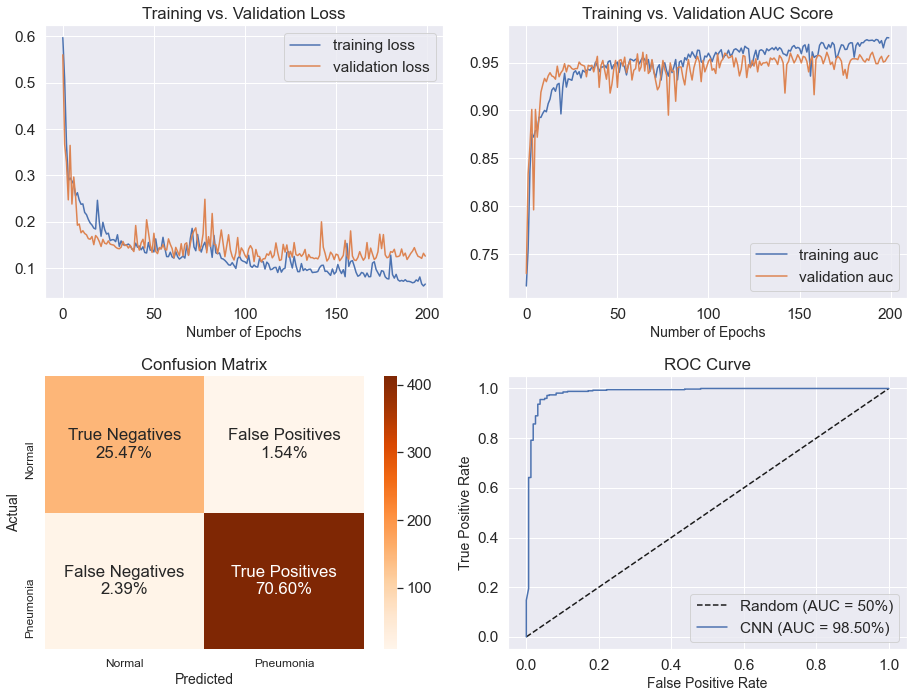

In [28]:
# Plot 

create_charts(cnn, cnn_model)

## Model 6: Convolution Layers = 3, Dense = 64, Epochs = 30, No Data Augmentation

In [71]:
# Load the images

train_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator,val_generator, test_generator = make_data_generator(
    train_datagen, train_dir,
    val_datagen, validation_dir,
    test_datagen, test_dir)

Found 4099 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 585 images belonging to 2 classes.


In [73]:
# Train the model

cnn_model = cnn.fit_generator(train_generator,
                              epochs = 30,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1)

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
33/33 [==============================] - 26s 785ms/step - loss: 0.6215 - acc: 0.6709 - val_loss: 0.5389 - val_acc: 0.7295
Epoch 2/30
33/33 [==============================] - 24s 740ms/step - loss: 0.4861 - acc: 0.7655 - val_loss: 0.3816 - val_acc: 0.7995
Epoch 3/30
33/33 [==============================] - 24s 741ms/step - loss: 0.3601 - acc: 0.8374 - val_loss: 0.2371 - val_acc: 0.9087
Epoch 4/30
33/33 [==============================] - 24s 745ms/step - loss: 0.2414 - acc: 0.8975 - val_loss: 0.1850 - val_acc: 0.9300
Epoch 5/30
33/33 [==============================] - 24s 738ms/step - loss: 0.1923 - acc: 0.9195 - val_loss: 0.2020 - val_acc: 0.9309
Epoch 6/30
33/33 [==============================] - 24s 741ms/step - loss: 0.2030 - acc: 0.9162 - val_loss: 0.1704 - val_acc: 0.9352
Epoch 7/30
33/33 [==============================] - 24s 735ms/step - loss: 0.1674 - acc: 0.9350 - val_loss: 0.1518 - val_acc: 0.9445
Epoch 8/30
33/33 [==============================] - 24s 744ms/step - 

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 96.24% | Precision = 96.55% | Recall = 98.36% | Specificity = 90.51% | F1 Score = 97.45%


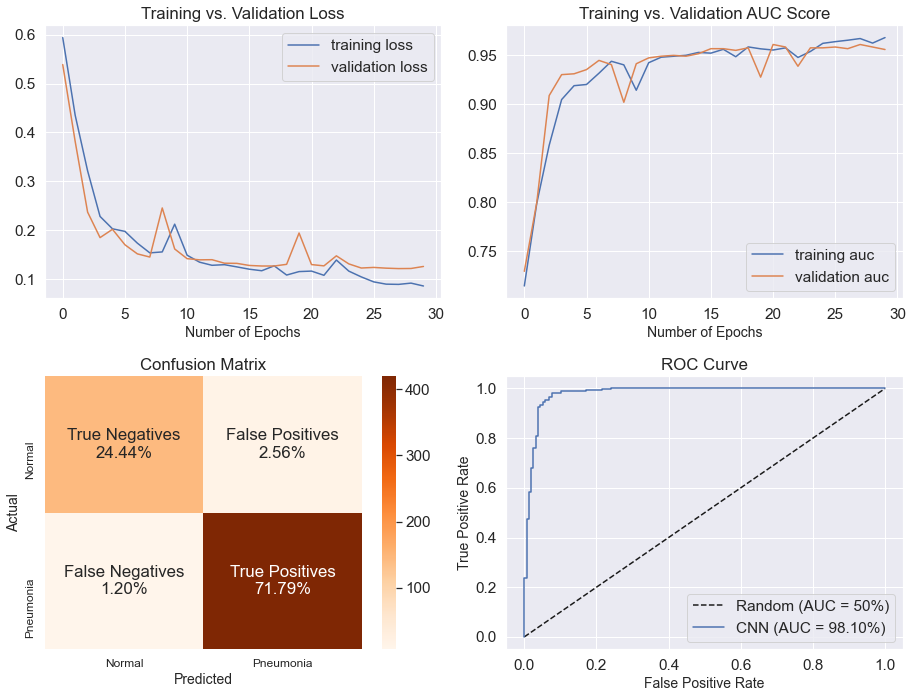

In [77]:
# Plot 

create_charts(cnn, cnn_model)

## Model 7: Convolution Layers = 3, Dense = 64, Epochs = 100, No Data Augmentation, BatchNormalization

In [83]:
def build_model_3():
    
    # Design the model
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(64, 64, 1)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))

    cnn.add(Flatten())
    
    cnn.add(BatchNormalization())
    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dense(1, activation='sigmoid'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

cnn = build_model_3()

In [35]:
cnn_model = cnn.fit_generator(train_generator,
                              epochs = 100,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1)

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
33/33 [==============================] - 26s 788ms/step - loss: 0.3821 - acc: 0.8477 - val_loss: 0.5202 - val_acc: 0.7295
Epoch 2/100
33/33 [==============================] - 25s 752ms/step - loss: 0.2230 - acc: 0.9104 - val_loss: 0.4829 - val_acc: 0.7295
Epoch 3/100
33/33 [==============================] - 25s 750ms/step - loss: 0.2141 - acc: 0.9166 - val_loss: 0.5038 - val_acc: 0.7295
Epoch 4/100
33/33 [==============================] - 25s 750ms/step - loss: 0.1862 - acc: 0.9270 - val_loss: 0.4893 - val_acc: 0.7304
Epoch 5/100
33/33 [==============================] - 25s 750ms/step - loss: 0.1766 - acc: 0.9326 - val_loss: 0.4879 - val_acc: 0.7304
Epoch 6/100
33/33 [==============================] - 25s 751ms/step - loss: 0.1699 - acc: 0.9376 - val_loss: 0.4492 - val_acc: 0.7295
Epoch 7/100
33/33 [==============================] - 25s 752ms/step - loss: 0.1492 - acc: 0.9434 - val_loss: 0.3392 - val_acc: 0.7901
Epoch 8/100
33/33 [==============================] - 25s 749ms

Epoch 62/100
33/33 [==============================] - 25s 749ms/step - loss: 0.1194 - acc: 0.9519 - val_loss: 0.1772 - val_acc: 0.9420
Epoch 63/100
33/33 [==============================] - 25s 756ms/step - loss: 0.1126 - acc: 0.9573 - val_loss: 0.2077 - val_acc: 0.9258
Epoch 64/100
33/33 [==============================] - 25s 749ms/step - loss: 0.0962 - acc: 0.9645 - val_loss: 0.1791 - val_acc: 0.9369
Epoch 65/100
33/33 [==============================] - 25s 747ms/step - loss: 0.1302 - acc: 0.9520 - val_loss: 0.1855 - val_acc: 0.9334
Epoch 66/100
33/33 [==============================] - 25s 749ms/step - loss: 0.1043 - acc: 0.9578 - val_loss: 0.2488 - val_acc: 0.9215
Epoch 67/100
33/33 [==============================] - 25s 754ms/step - loss: 0.0975 - acc: 0.9647 - val_loss: 0.1462 - val_acc: 0.9480
Epoch 68/100
33/33 [==============================] - 25s 758ms/step - loss: 0.1067 - acc: 0.9627 - val_loss: 5.7494 - val_acc: 0.7295
Epoch 69/100
33/33 [==============================] - 2

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 94.19% | Precision = 94.97% | Recall = 97.19% | Specificity = 86.08% | F1 Score = 96.06%


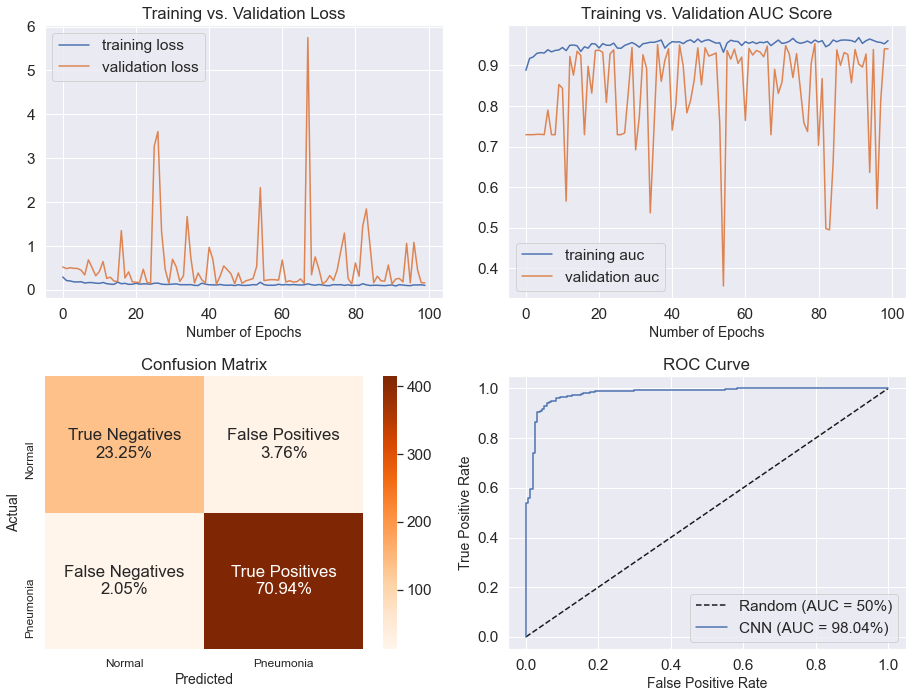

In [36]:
create_charts(cnn, cnn_model)

## Model 8: Convolution Layers = 3, Dense = （128 64）, Epochs = 100, No Data Augmentation, BatchNormalization

In [86]:
def build_model_5():
    # Design the model

    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(64, 64, 1)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))

    cnn.add(Flatten())

    cnn.add(BatchNormalization())
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dense(1, activation='sigmoid'))

    # Compile

    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

In [87]:
cnn = build_model_5()

In [38]:
cnn_model = cnn.fit_generator(train_generator,
                              epochs = 100,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1)

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
33/33 [==============================] - 26s 807ms/step - loss: 0.4100 - acc: 0.8515 - val_loss: 0.5268 - val_acc: 0.7295
Epoch 2/100
33/33 [==============================] - 25s 752ms/step - loss: 0.2227 - acc: 0.9066 - val_loss: 0.4882 - val_acc: 0.7295
Epoch 3/100
33/33 [==============================] - 25s 750ms/step - loss: 0.2024 - acc: 0.9226 - val_loss: 0.4876 - val_acc: 0.7295
Epoch 4/100
33/33 [==============================] - 25s 752ms/step - loss: 0.1959 - acc: 0.9202 - val_loss: 0.4741 - val_acc: 0.7295
Epoch 5/100
33/33 [==============================] - 25s 750ms/step - loss: 0.1701 - acc: 0.9365 - val_loss: 0.4234 - val_acc: 0.8328
Epoch 6/100
33/33 [==============================] - 25s 751ms/step - loss: 0.1575 - acc: 0.9363 - val_loss: 0.3974 - val_acc: 0.7730
Epoch 7/100
33/33 [==============================] - 25s 750ms/step - loss: 0.1852 - acc: 0.9268 - val_loss: 0.3593 - val_acc: 0.8200
Epoch 8/100
33/33 [==============================] - 25s 749ms

Epoch 62/100
33/33 [==============================] - 25s 749ms/step - loss: 0.1391 - acc: 0.9437 - val_loss: 0.1720 - val_acc: 0.9377
Epoch 63/100
33/33 [==============================] - 25s 750ms/step - loss: 0.1177 - acc: 0.9528 - val_loss: 0.1393 - val_acc: 0.9420
Epoch 64/100
33/33 [==============================] - 25s 747ms/step - loss: 0.1115 - acc: 0.9525 - val_loss: 0.1521 - val_acc: 0.9420
Epoch 65/100
33/33 [==============================] - 25s 748ms/step - loss: 0.1390 - acc: 0.9456 - val_loss: 0.1537 - val_acc: 0.9411
Epoch 66/100
33/33 [==============================] - 25s 750ms/step - loss: 0.1251 - acc: 0.9496 - val_loss: 0.1584 - val_acc: 0.9403
Epoch 67/100
33/33 [==============================] - 25s 750ms/step - loss: 0.1180 - acc: 0.9575 - val_loss: 0.1432 - val_acc: 0.9514
Epoch 68/100
33/33 [==============================] - 25s 751ms/step - loss: 0.1025 - acc: 0.9622 - val_loss: 0.1376 - val_acc: 0.9454
Epoch 69/100
33/33 [==============================] - 2

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 91.97% | Precision = 96.80% | Recall = 92.04% | Specificity = 91.77% | F1 Score = 94.36%


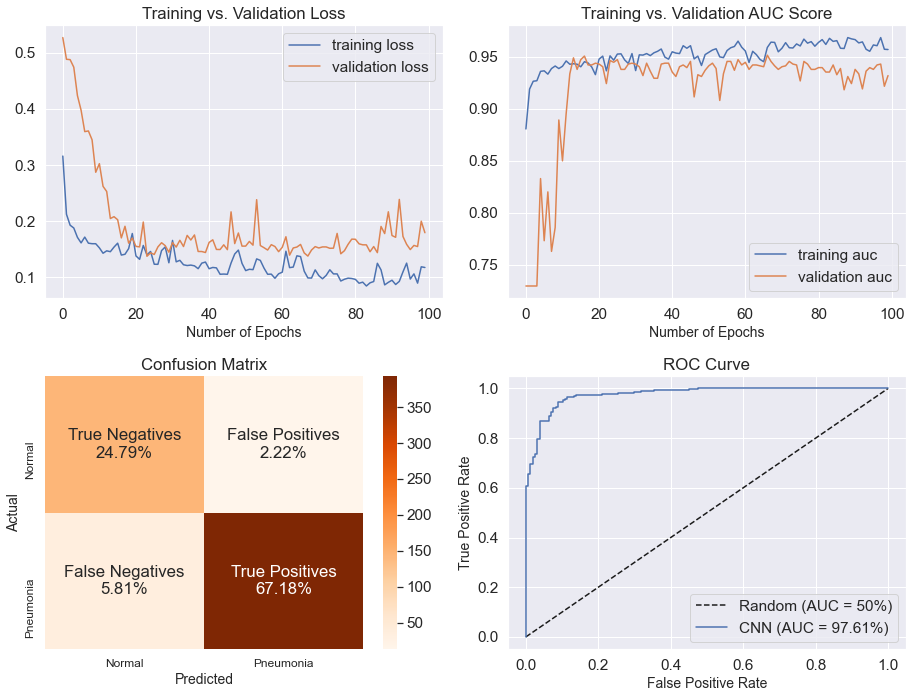

In [39]:
create_charts(cnn, cnn_model)

## Model 9: Convolution Layers = 3, Dense = (128 64), Epochs = 100, No Data Augmentation

In [88]:
def build_model_6():
    # Design the model

    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(64, 64, 1)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))

    cnn.add(Flatten())

    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dense(1, activation='sigmoid'))

    # Compile

    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

In [89]:
cnn = build_model_6()

In [41]:
cnn_model = cnn.fit_generator(train_generator,
                              epochs = 100,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1)

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
33/33 [==============================] - 26s 788ms/step - loss: 0.6056 - acc: 0.7285 - val_loss: 0.5283 - val_acc: 0.7295
Epoch 2/100
33/33 [==============================] - 25s 753ms/step - loss: 0.4934 - acc: 0.7649 - val_loss: 0.3594 - val_acc: 0.8464
Epoch 3/100
33/33 [==============================] - 25s 751ms/step - loss: 0.3351 - acc: 0.8448 - val_loss: 0.2458 - val_acc: 0.8993
Epoch 4/100
33/33 [==============================] - 25s 748ms/step - loss: 0.3374 - acc: 0.8556 - val_loss: 0.2474 - val_acc: 0.9002
Epoch 5/100
33/33 [==============================] - 25s 751ms/step - loss: 0.3167 - acc: 0.8631 - val_loss: 0.2896 - val_acc: 0.8891
Epoch 6/100
33/33 [==============================] - 25s 753ms/step - loss: 0.2963 - acc: 0.8764 - val_loss: 0.2466 - val_acc: 0.8951
Epoch 7/100
33/33 [==============================] - 25s 751ms/step - loss: 0.2699 - acc: 0.8755 - val_loss: 0.1854 - val_acc: 0.9292
Epoch 8/100
33/33 [==============================] - 25s 752ms

Epoch 62/100
33/33 [==============================] - 24s 734ms/step - loss: 0.1597 - acc: 0.9364 - val_loss: 0.1329 - val_acc: 0.9514
Epoch 63/100
33/33 [==============================] - 24s 735ms/step - loss: 0.1405 - acc: 0.9442 - val_loss: 0.1382 - val_acc: 0.9428
Epoch 64/100
33/33 [==============================] - 24s 731ms/step - loss: 0.1339 - acc: 0.9498 - val_loss: 0.1461 - val_acc: 0.9411
Epoch 65/100
33/33 [==============================] - 24s 732ms/step - loss: 0.1589 - acc: 0.9385 - val_loss: 0.1986 - val_acc: 0.9215
Epoch 66/100
33/33 [==============================] - 24s 733ms/step - loss: 0.1892 - acc: 0.9289 - val_loss: 0.1461 - val_acc: 0.9531
Epoch 67/100
33/33 [==============================] - 24s 736ms/step - loss: 0.1351 - acc: 0.9524 - val_loss: 0.1438 - val_acc: 0.9488
Epoch 68/100
33/33 [==============================] - 24s 735ms/step - loss: 0.1468 - acc: 0.9465 - val_loss: 0.1668 - val_acc: 0.9369
Epoch 69/100
33/33 [==============================] - 2

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 93.85% | Precision = 95.57% | Recall = 96.02% | Specificity = 87.97% | F1 Score = 95.79%


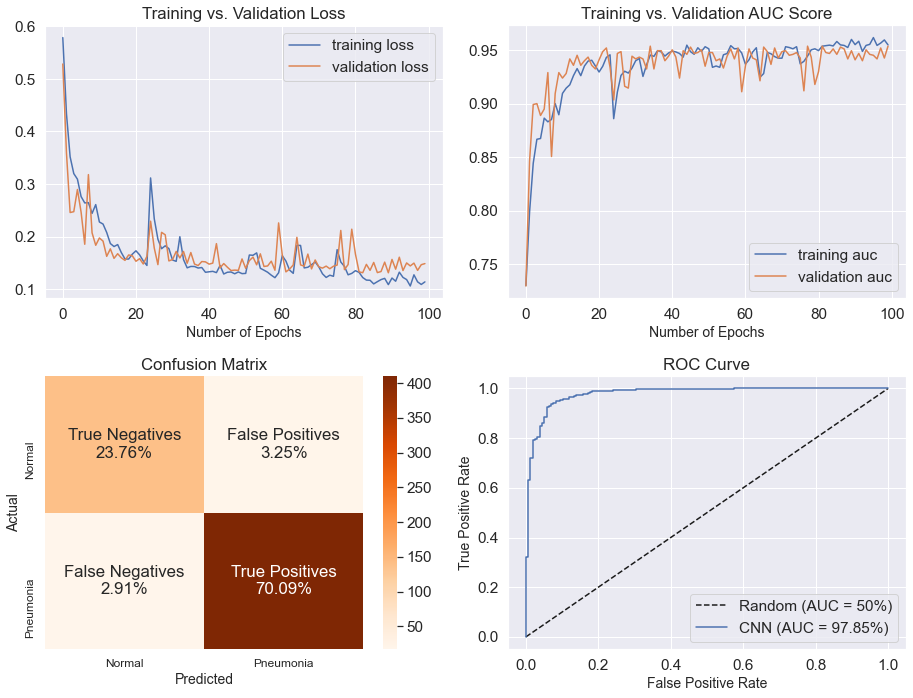

In [42]:
create_charts(cnn, cnn_model)

## Model 10: Convolution Layers = 3, Dense = (128,64), Epochs = 100, Data Augmentation, filter(32,64,64), Batch Normalization, Dropout layers

In [29]:
# Load the images

train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   zoom_range = 0.2,
                                   shear_range = 0.2,
                                   horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator,val_generator, test_generator = make_data_generator(
    train_datagen, train_dir,
    val_datagen, validation_dir,
    test_datagen, test_dir)


Found 4099 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 585 images belonging to 2 classes.


In [81]:
# Design the model
def build_model_7():

    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(64, 64, 1)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))

    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))

    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))

    cnn.add(Flatten())

    cnn.add(BatchNormalization())
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dropout(0.2))
    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dropout(0.2))
    cnn.add(Dense(1, activation='sigmoid'))

    # Compile

    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    
    return cnn

In [82]:
cnn = build_model_7

In [31]:
cnn_model = cnn.fit_generator(train_generator,
                              epochs = 100,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1)

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
33/33 [==============================] - 27s 800ms/step - loss: 0.6617 - acc: 0.6180 - val_loss: 0.8516 - val_acc: 0.7295
Epoch 2/100
33/33 [==============================] - 25s 764ms/step - loss: 0.4441 - acc: 0.7958 - val_loss: 2.4615 - val_acc: 0.7295
Epoch 3/100
33/33 [==============================] - 25s 758ms/step - loss: 0.3998 - acc: 0.8284 - val_loss: 1.7124 - val_acc: 0.7287
Epoch 4/100
33/33 [==============================] - 25s 764ms/step - loss: 0.3772 - acc: 0.8352 - val_loss: 1.4912 - val_acc: 0.7287
Epoch 5/100
33/33 [==============================] - 25s 758ms/step - loss: 0.3738 - acc: 0.8381 - val_loss: 1.4701 - val_acc: 0.7227
Epoch 6/100
33/33 [==============================] - 25s 761ms/step - loss: 0.3656 - acc: 0.8439 - val_loss: 1.6165 - val_acc: 0.7235
Epoch 7/100
33/33 [==============================] - 25s 763ms/step - loss: 0.3568 - acc: 0.8511 - val_loss: 0.3642 - val_acc: 0.8456
Epoch 8/100
33/33 [==============================] - 25s 757ms

Epoch 62/100
33/33 [==============================] - 25s 745ms/step - loss: 0.3198 - acc: 0.8628 - val_loss: 0.7985 - val_acc: 0.6160
Epoch 63/100
33/33 [==============================] - 25s 742ms/step - loss: 0.3515 - acc: 0.8514 - val_loss: 2.4151 - val_acc: 0.2961
Epoch 64/100
33/33 [==============================] - 25s 743ms/step - loss: 0.3352 - acc: 0.8563 - val_loss: 0.9662 - val_acc: 0.7474
Epoch 65/100
33/33 [==============================] - 24s 763ms/step - loss: 0.3585 - acc: 0.8579 - val_loss: 0.6917 - val_acc: 0.7440
Epoch 66/100
33/33 [==============================] - 24s 742ms/step - loss: 0.3127 - acc: 0.8713 - val_loss: 0.4330 - val_acc: 0.8003
Epoch 67/100
33/33 [==============================] - 25s 747ms/step - loss: 0.3491 - acc: 0.8401 - val_loss: 0.3828 - val_acc: 0.8063
Epoch 68/100
33/33 [==============================] - 25s 749ms/step - loss: 0.3137 - acc: 0.8679 - val_loss: 0.5045 - val_acc: 0.7850
Epoch 69/100
33/33 [==============================] - 2

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 91.45% | Precision = 94.77% | Recall = 93.44% | Specificity = 86.08% | F1 Score = 94.10%


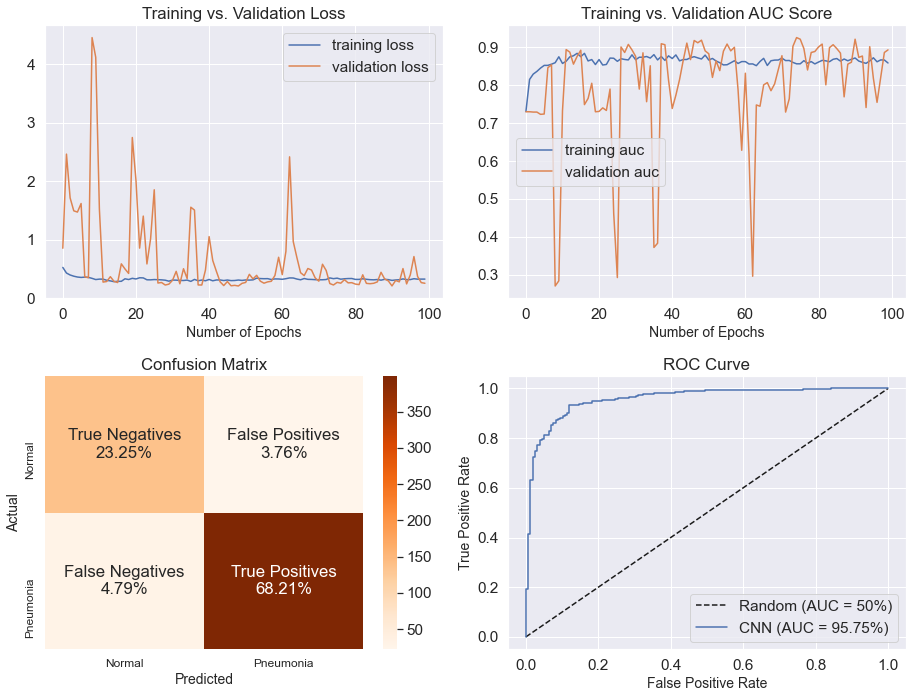

In [32]:
# Plot 

create_charts(cnn, cnn_model)

## Results
 - Model 6 performs the best.
 - Through each epoch during the learning process, validation loss and training loss approach each other, which means our model dosen't have much overfitting or underfitting. Moreover, traning and validation accuracy score also converges to some points where they are almost equal in the end.
 - The model has an accuracy score 96.24%, which indicates that our CNN model performs really well to classify 96.24% of the images in the test set.
 - For the case of detecting penumonia, we will aim to have high recall as any delayed diagonosis means that someome may get really sick and potential lose their life.The model has an recall score 98.36% with 2.56% false positives and 1.20% false negatives, which are impressively good and exactly what we are aiming for. 
 
## Conclusion
- Our CNN model can effectively detect pneumonia disease with extremely high accuracy. 
- Radiologists could combine this model and their expertise to make highly accurate diagnosis of Pneumonia.
 
 
## Future Work
 - To make the model more robust, inscrease the number and diversity in the dataset. For example, include X-ray images from patients in different countires and at different age.
 - Our current model is a binary classification model, identifying whether the patient has Pneumonia or not. In reality, patients could be suffering from different types of lung disease. In the future, I would love to collect different types of lung X-ray images and build a model to automatically diagnosis the type of lung disease.
